In [1]:
import os
import json
import torch
import random
import pickle
import skfmm
import numpy as np
from evaluation import *
from functions import *
import torch.optim as optim
from torch.utils.data import TensorDataset
from Models.AutoEncoder import AutoEncoder
from Models.AutoEncoderEx import AutoEncoderEx
from Models.UNet import UNet
from Models.UNetEx import UNetEx
from matplotlib import pyplot as plt

In [2]:
# Loading dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
mask = (1 - torch.isnan(x[:, 2:, :, :]).type(torch.float))
mask[:, 0, 0, :] = 3
mask[:, 0, mask.shape[2]-1, :] = 4
mask[:, 0, :, 0] = 2
mask[:, 0, :, mask.shape[3]-1] = 2
x = torch.cat((x[:, 0:1, :, :], mask), dim=1)
# Adding sdf from walls
phi = -1*np.ones(x[0, 0, :, :].shape)
phi = phi.reshape((1, 1, phi.shape[0], phi.shape[1]))
sdf = np.array(phi, copy=True)
sdf[0, 0, :, 0] = 1
sdf[0, 0, :, 78] = 1
d = skfmm.distance(-sdf, dx = 1e-2)
d = np.repeat(d, x.shape[0], axis=0)
d = torch.FloatTensor(d)
x = torch.cat((x, d), dim=1)
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0
channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(channels_weights)
print(x.shape)
print(y.shape)
# Shuffling the dataset
x, y = shuffle_tensors(x, y)
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

test_sample_x, test_sample_y = test_dataset[random.randint(0, len(test_dataset))]
test_sample_x, test_sample_y = test_sample_x.unsqueeze(0).to(device), test_sample_y.unsqueeze(0).to(device)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')
torch.Size([961, 3, 172, 79])
torch.Size([961, 3, 172, 79])


In [3]:
simulations = 10
epochs = 20
batch_size = 32
config = {
    "model": AutoEncoder,
    "lr": 0.001,
    "kernel": 5,
    "filters": [8, 16, 32],
    "wn": False,
    "bn": False,
    "wd": 0.005
}

Evaluating configuration: 
{'model': <class 'Models.AutoEncoder.AutoEncoder'>, 'lr': 0.001, 'kernel': 5, 'filters': [8, 16, 32], 'wn': False, 'bn': False, 'wd': 0.005}
Epoch #1
	Train Loss = 44693708.875
	Train Total MSE = 169.86892754690987
	Train Ux MSE = 100.52179409208752
	Train Uy MSE = 52.191077414013094
	Train p MSE = 17.15605661982582
	Validation Loss = 7555156.8828125
	Validation Total MSE = 44.50533021445093
	Validation Ux MSE = 35.7205603576449
	Validation Uy MSE = 5.717724275423993
	Validation p MSE = 3.0670454444357267
Model saved!
Epoch #2
	Train Loss = 16073407.0625
	Train Total MSE = 46.840915134974885
	Train Ux MSE = 37.89087204706101
	Train Uy MSE = 6.131266185215542
	Train p MSE = 2.8187769026983354
	Validation Loss = 6553690.666015625
	Validation Total MSE = 45.832803627198956
	Validation Ux MSE = 38.43423448714418
	Validation Uy MSE = 4.916584351483514
	Validation p MSE = 2.481984675549306
Model saved!
Epoch #3
	Train Loss = 13361129.8125
	Train Total MSE = 44.3466

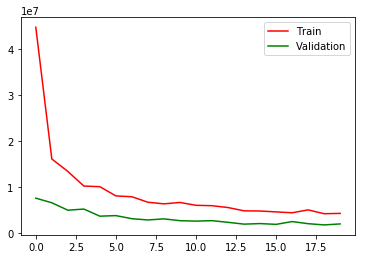

MSE: 


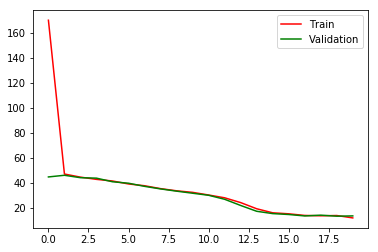

Ux: 


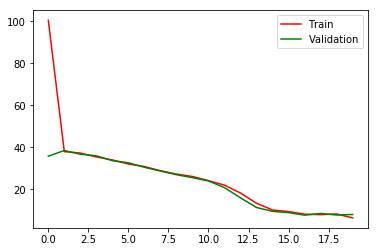

Uy: 


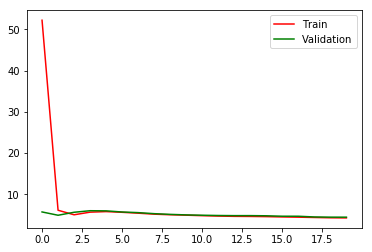

p: 


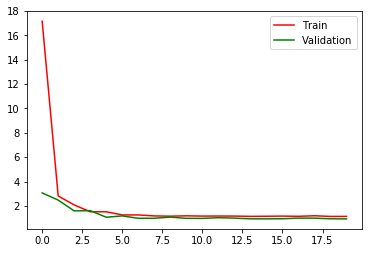

Output: 


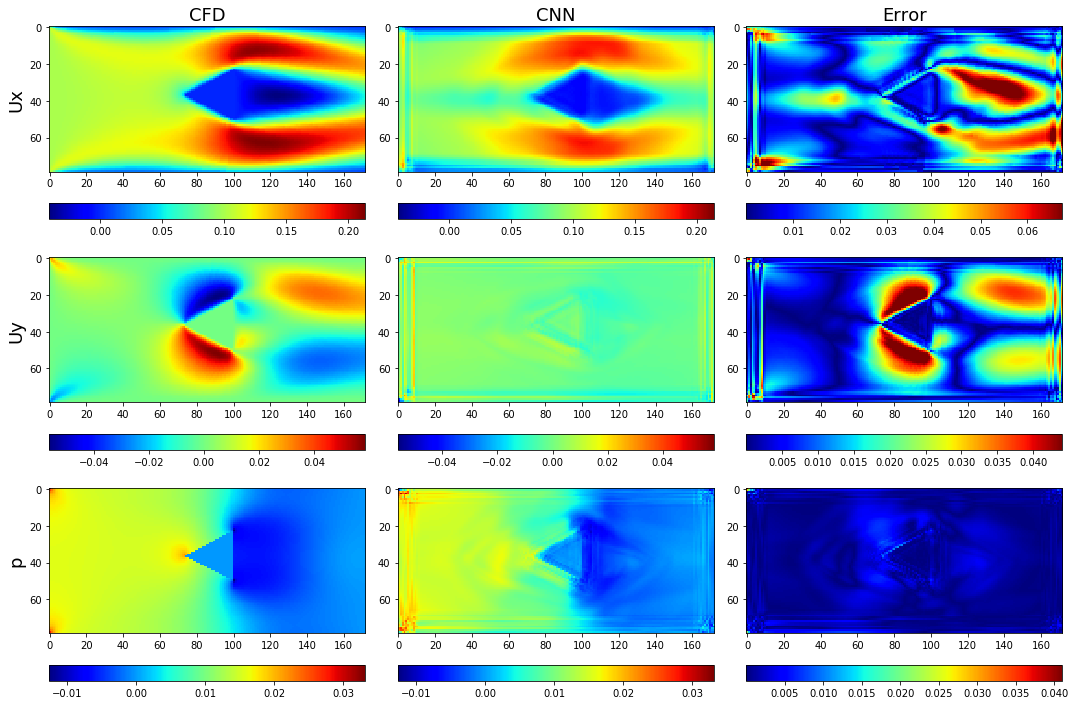

Best loss = 1739745.7951660156
Epoch #1
	Train Loss = 24999212.5
	Train Total MSE = 120.63131550380162
	Train Ux MSE = 48.36165382748558
	Train Uy MSE = 68.63577474866595
	Train p MSE = 3.633887461253575
	Validation Loss = 6940707.2890625
	Validation Total MSE = 52.97537243324992
	Validation Ux MSE = 42.027164710021765
	Validation Uy MSE = 8.753115964183346
	Validation p MSE = 2.195091383267439
Model saved!
Epoch #2
	Train Loss = 14788654.0625
	Train Total MSE = 48.682556333996004
	Train Ux MSE = 39.86521185012091
	Train Uy MSE = 6.555289359319778
	Train p MSE = 2.262054437682742
	Validation Loss = 6220831.9453125
	Validation Total MSE = 48.8092150704671
	Validation Ux MSE = 39.64493009045875
	Validation Uy MSE = 7.101265326503239
	Validation p MSE = 2.0630200754812433
Model saved!
Epoch #3
	Train Loss = 13862605.8125
	Train Total MSE = 47.125569661458336
	Train Ux MSE = 38.8838259379069
	Train Uy MSE = 6.140920911516462
	Train p MSE = 2.1008222982996987
	Validation Loss = 6532700.3945

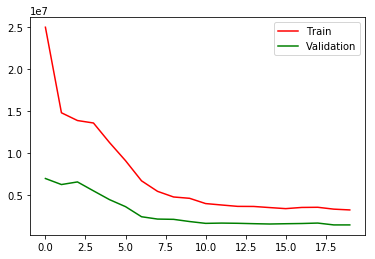

MSE: 


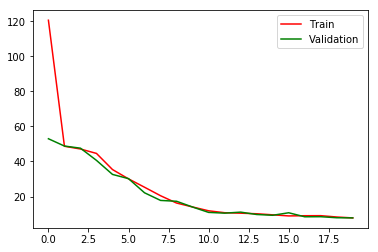

Ux: 


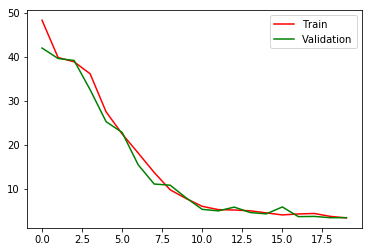

Uy: 


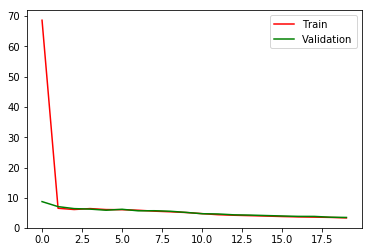

p: 


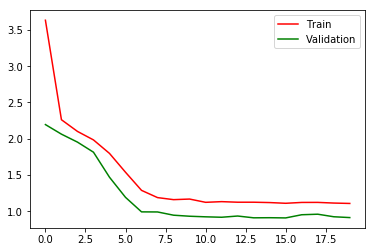

Output: 


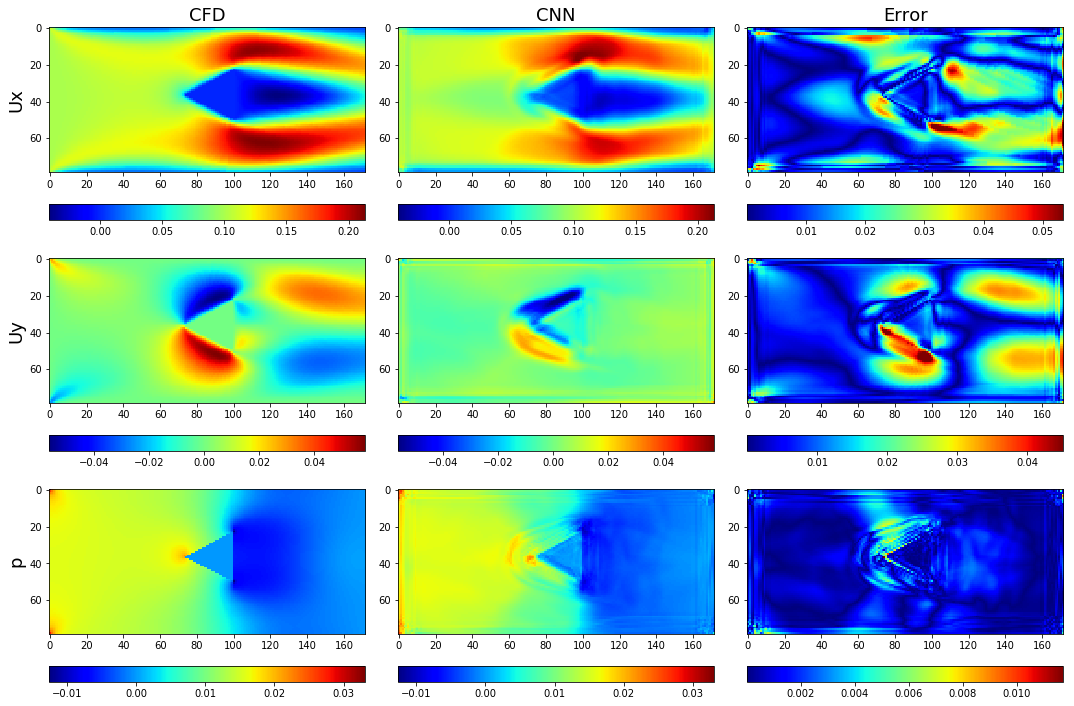

Best loss = 1400751.8186035156
Epoch #1
	Train Loss = 22325847.6875
	Train Total MSE = 54.08663322812035
	Train Ux MSE = 42.86488796415783
	Train Uy MSE = 5.608752182551792
	Train p MSE = 5.6129942905335195
	Validation Loss = 6765908.314453125
	Validation Total MSE = 49.79072752955876
	Validation Ux MSE = 42.38997742543996
	Validation Uy MSE = 4.6704716929927415
	Validation p MSE = 2.730278693680945
Model saved!
Epoch #2
	Train Loss = 13174006.3125
	Train Total MSE = 45.656411488850914
	Train Ux MSE = 39.0828481401716
	Train Uy MSE = 4.382839747837612
	Train p MSE = 2.1907227550234114
	Validation Loss = 4997527.71875
	Validation Total MSE = 42.83672108369715
	Validation Ux MSE = 36.56776230227989
	Validation Uy MSE = 4.625160642973692
	Validation p MSE = 1.6437983956303976
Model saved!
Epoch #3
	Train Loss = 9387473.15625
	Train Total MSE = 38.83167702811105
	Train Ux MSE = 32.957912990025115
	Train Uy MSE = 4.38342775617327
	Train p MSE = 1.4903358675184704
	Validation Loss = 3208409.

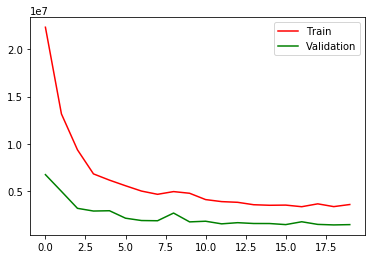

MSE: 


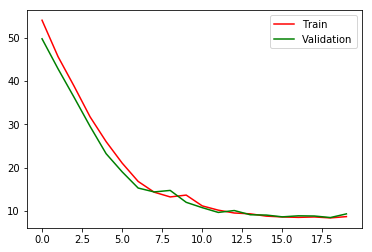

Ux: 


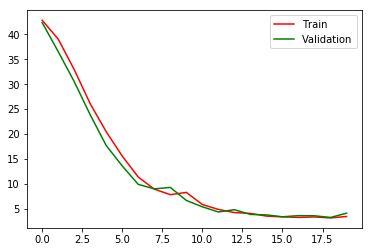

Uy: 


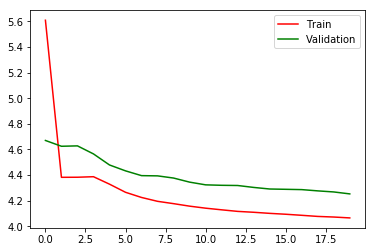

p: 


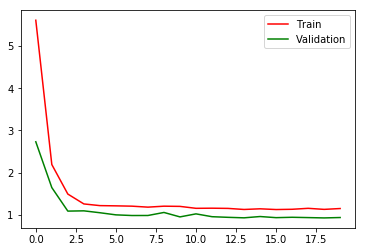

Output: 


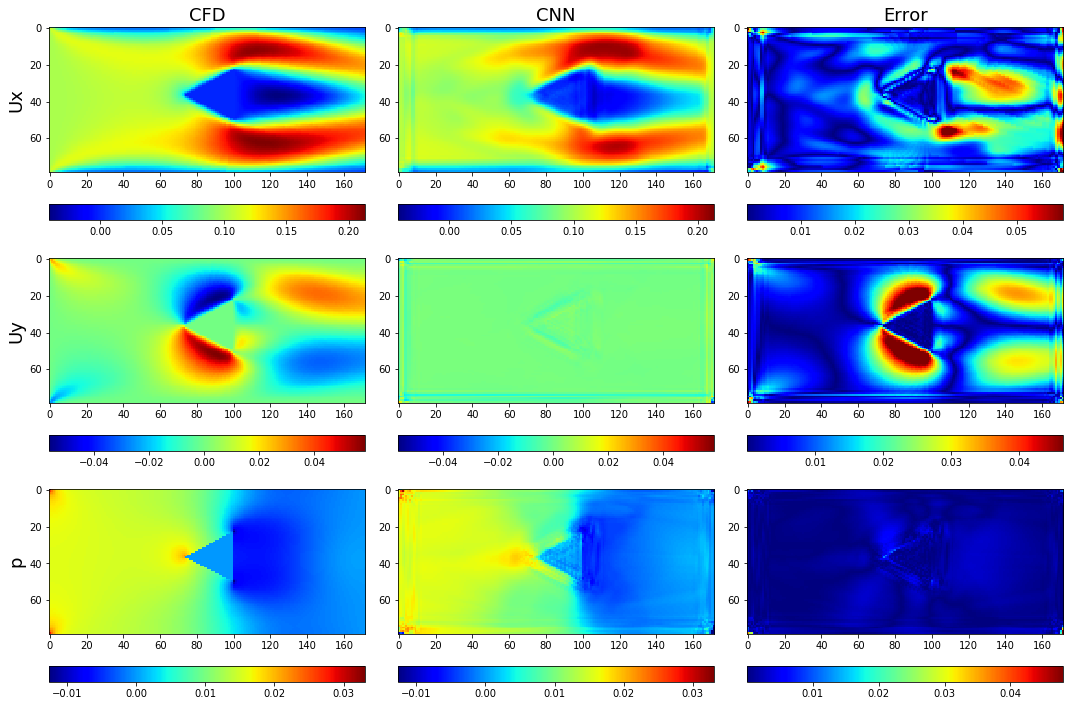

Best loss = 1457602.6694335938
Epoch #1
	Train Loss = 29712505.6875
	Train Total MSE = 173.03116571335565
	Train Ux MSE = 139.59804553077333
	Train Uy MSE = 29.989058017730713
	Train p MSE = 3.444060064497448
	Validation Loss = 7508671.619140625
	Validation Total MSE = 59.55569820998037
	Validation Ux MSE = 48.15125893721531
	Validation Uy MSE = 8.319991507744707
	Validation p MSE = 3.0844482212330644
Model saved!
Epoch #2
	Train Loss = 13229503.875
	Train Total MSE = 42.12543787275042
	Train Ux MSE = 32.048877261933825
	Train Uy MSE = 7.884341466994512
	Train p MSE = 2.192219609305972
	Validation Loss = 4253191.525390625
	Validation Total MSE = 30.333691514487086
	Validation Ux MSE = 22.936316480273607
	Validation Uy MSE = 5.795083131757162
	Validation p MSE = 1.602291518532281
Model saved!
Epoch #3
	Train Loss = 8919485.9375
	Train Total MSE = 28.075223468598864
	Train Ux MSE = 21.15183094569615
	Train Uy MSE = 5.4186018989199685
	Train p MSE = 1.504790913491022
	Validation Loss = 34

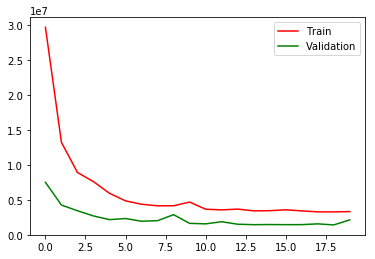

MSE: 


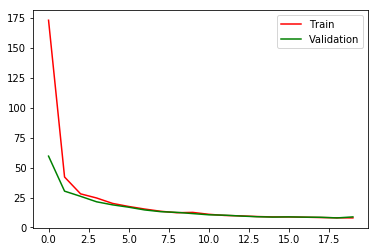

Ux: 


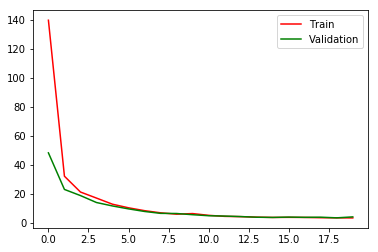

Uy: 


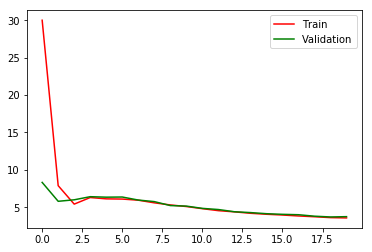

p: 


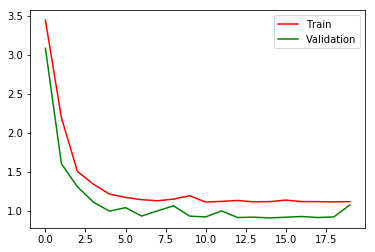

Output: 


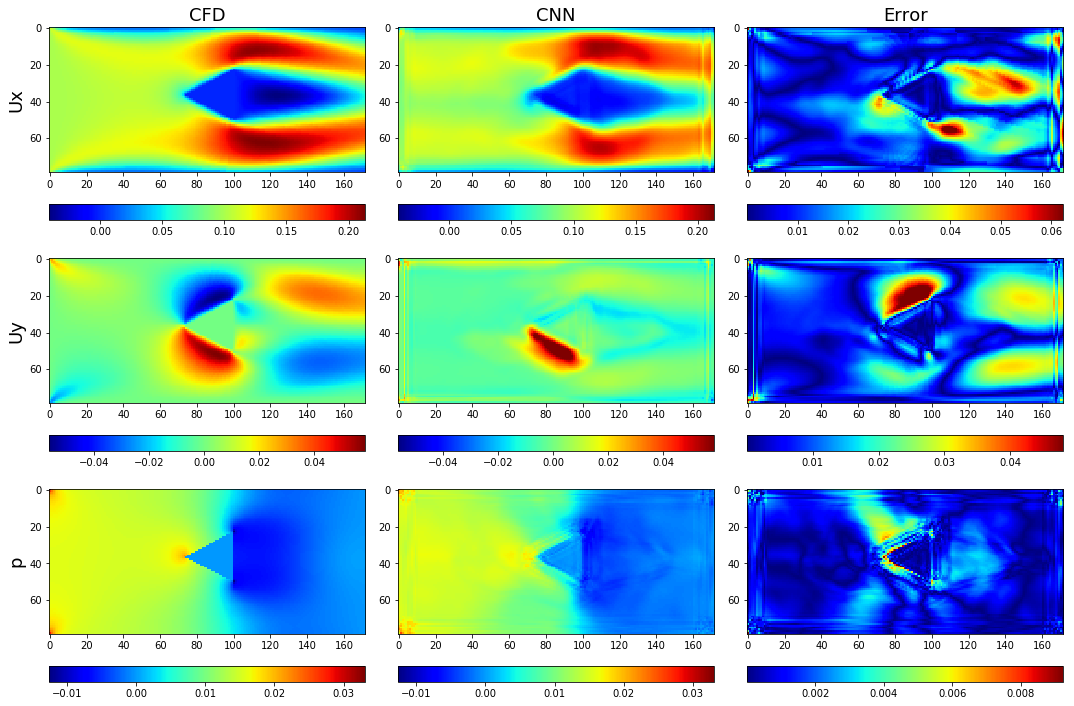

Best loss = 1408826.3110351562
Epoch #1
	Train Loss = 44928419.25
	Train Total MSE = 116.91144470941452
	Train Ux MSE = 74.84578105381557
	Train Uy MSE = 20.991862456003826
	Train p MSE = 21.073802743639266
	Validation Loss = 9021024.791015625
	Validation Total MSE = 51.073832765995014
	Validation Ux MSE = 40.92488327818346
	Validation Uy MSE = 5.501159164732303
	Validation p MSE = 4.647790841165299
Model saved!
Epoch #2
	Train Loss = 17357843.6875
	Train Total MSE = 49.09169660295759
	Train Ux MSE = 39.740021115257626
	Train Uy MSE = 5.826766559055874
	Train p MSE = 3.524909734725952
	Validation Loss = 7161777.69140625
	Validation Total MSE = 48.85622685838323
	Validation Ux MSE = 40.30669178682215
	Validation Uy MSE = 5.390522674705743
	Validation p MSE = 3.159012888954585
Model saved!
Epoch #3
	Train Loss = 15937346.375
	Train Total MSE = 47.11518423897879
	Train Ux MSE = 38.801346915108816
	Train Uy MSE = 5.2261746270315985
	Train p MSE = 3.0876631963820684
	Validation Loss = 67622

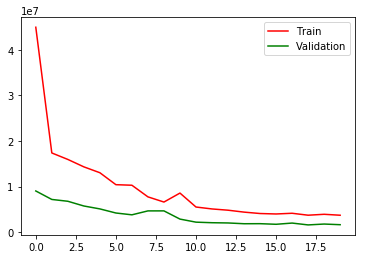

MSE: 


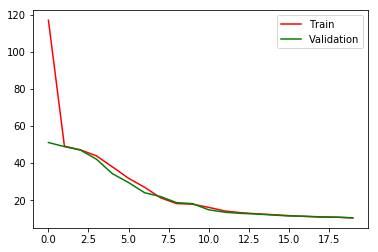

Ux: 


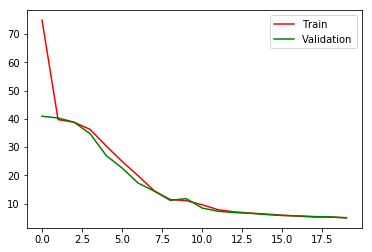

Uy: 


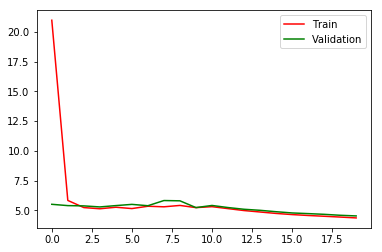

p: 


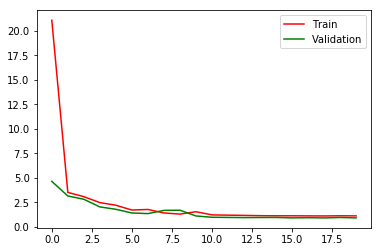

Output: 


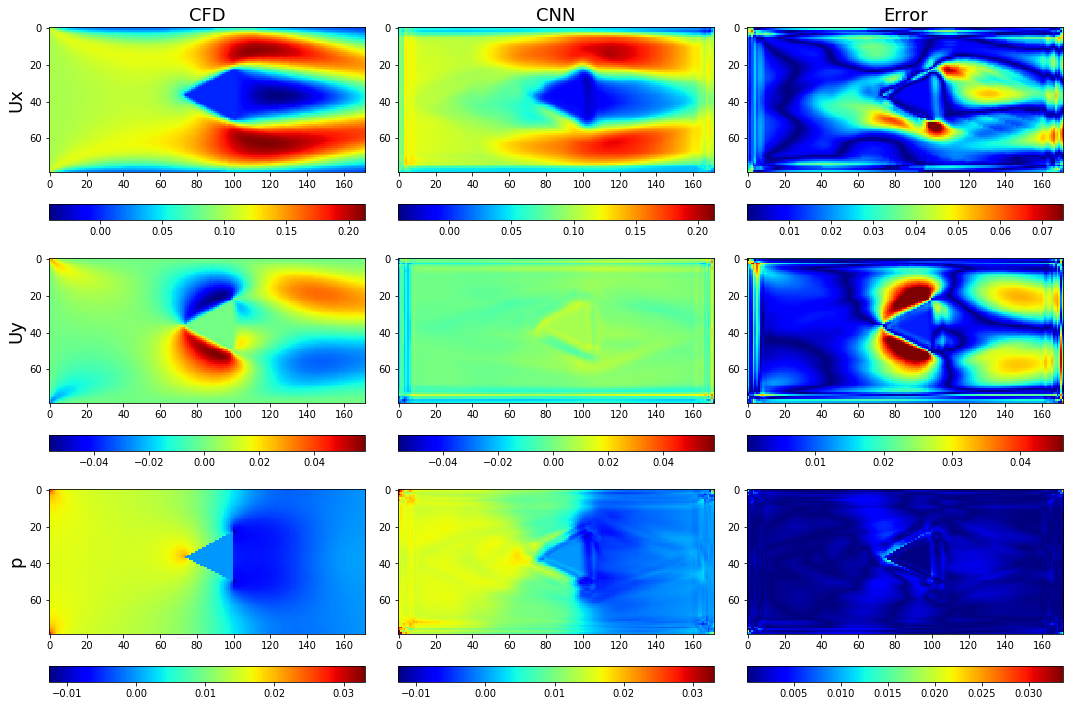

Best loss = 1576014.3625488281
Epoch #1
	Train Loss = 56537036.75
	Train Total MSE = 442.00060017903644
	Train Ux MSE = 430.45028395879837
	Train Uy MSE = 7.514600867316837
	Train p MSE = 4.035720416477749
	Validation Loss = 14463424.8125
	Validation Total MSE = 235.7306529114403
	Validation Ux MSE = 227.99621856583855
	Validation Uy MSE = 5.531584667087014
	Validation p MSE = 2.202851366006792
Model saved!
Epoch #2
	Train Loss = 18401633.5625
	Train Total MSE = 75.1224723089309
	Train Ux MSE = 67.37793840680804
	Train Uy MSE = 5.192705495016916
	Train p MSE = 2.551826011566889
	Validation Loss = 6332300.015625
	Validation Total MSE = 43.3920152129599
	Validation Ux MSE = 36.409568238835845
	Validation Uy MSE = 4.897473757654738
	Validation p MSE = 2.0849740356722504
Model saved!
Epoch #3
	Train Loss = 12920613.46875
	Train Total MSE = 32.491146450950986
	Train Ux MSE = 25.43077196393694
	Train Uy MSE = 4.883771737416585
	Train p MSE = 2.176602298305148
	Validation Loss = 5299730.21679

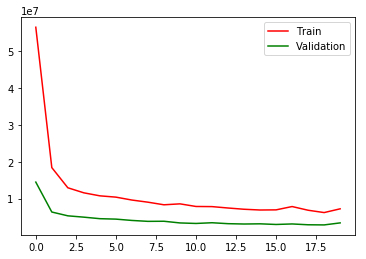

MSE: 


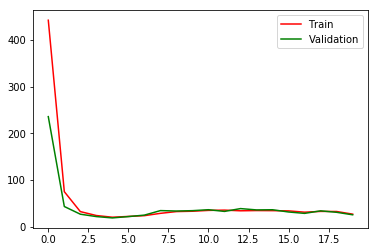

Ux: 


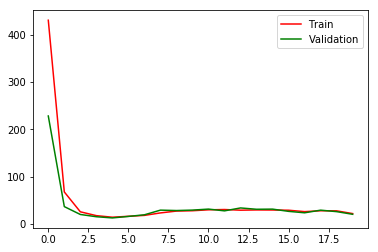

Uy: 


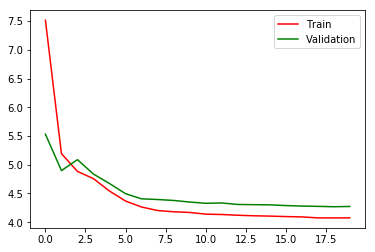

p: 


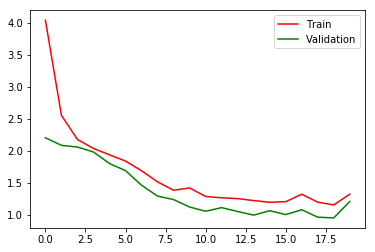

Output: 


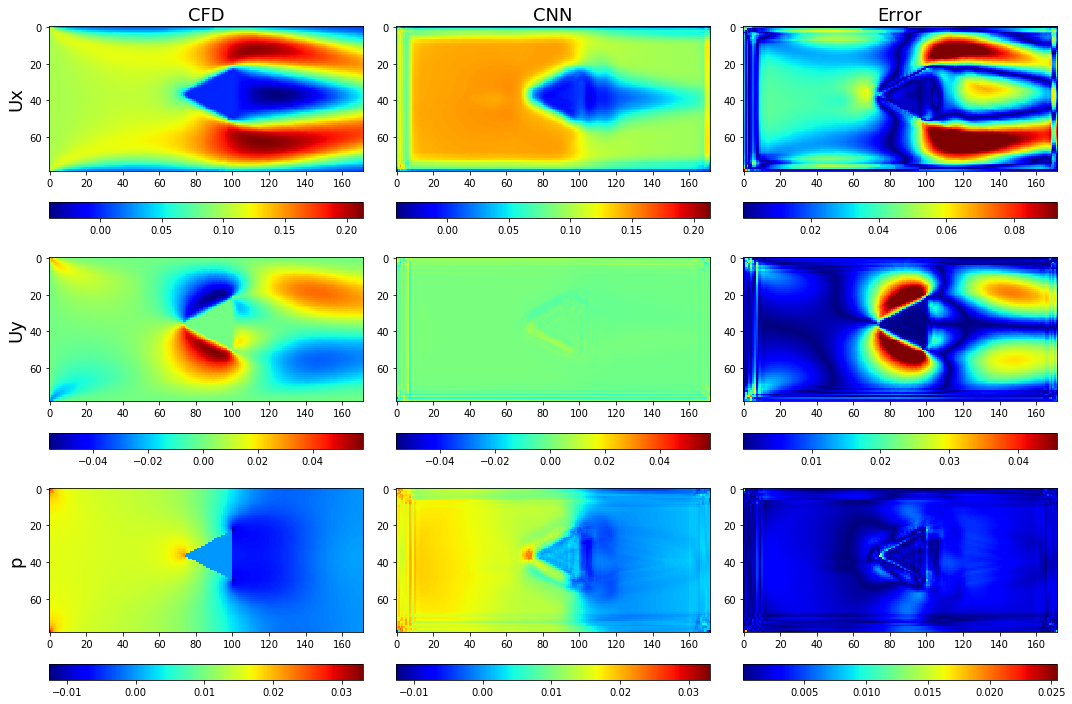

Best loss = 2829937.228515625
Epoch #1
	Train Loss = 76414882.5
	Train Total MSE = 316.2444868541899
	Train Ux MSE = 152.83592478434244
	Train Uy MSE = 120.23656699770973
	Train p MSE = 43.17200149808611
	Validation Loss = 9346311.005859375
	Validation Total MSE = 60.37875928515794
	Validation Ux MSE = 46.060023878684916
	Validation Uy MSE = 8.793520590838265
	Validation p MSE = 5.525214347047377
Model saved!
Epoch #2
	Train Loss = 18934065.3125
	Train Total MSE = 57.317193349202476
	Train Ux MSE = 43.34551166352772
	Train Uy MSE = 9.617690109071278
	Train p MSE = 4.353992621103923
	Validation Loss = 7390276.830078125
	Validation Total MSE = 52.122082825763
	Validation Ux MSE = 41.47246150244479
	Validation Uy MSE = 7.316815079289737
	Validation p MSE = 3.332807539243599
Model saved!
Epoch #3
	Train Loss = 15468879.0625
	Train Total MSE = 49.15406218029204
	Train Ux MSE = 39.62829953148251
	Train Uy MSE = 6.378074873061407
	Train p MSE = 3.1476887578055974
	Validation Loss = 6061019.67

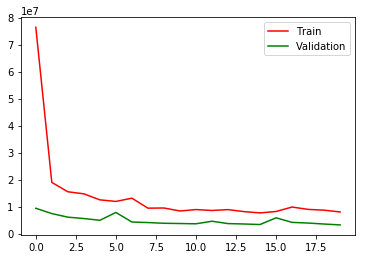

MSE: 


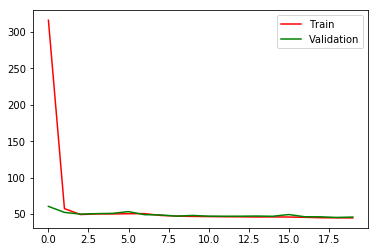

Ux: 


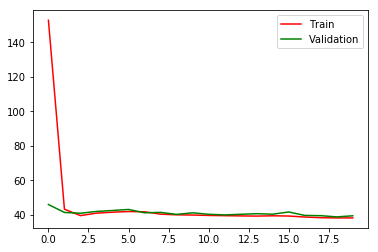

Uy: 


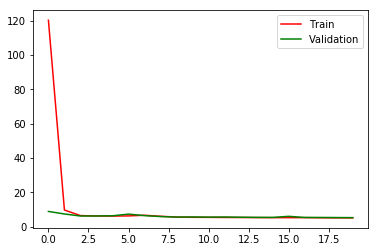

p: 


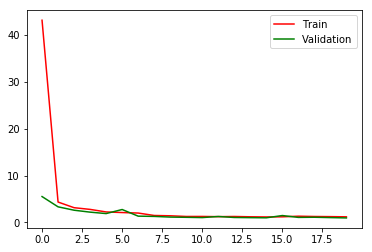

Output: 


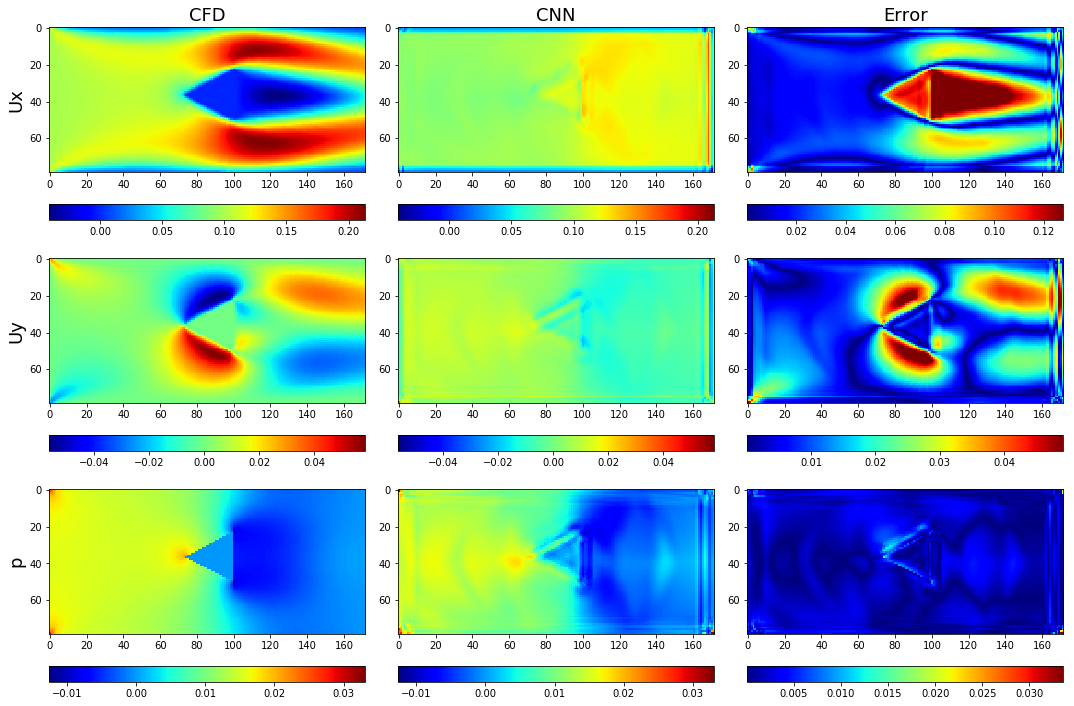

Best loss = 3185936.5087890625
Epoch #1
	Train Loss = 87335112.0
	Train Total MSE = 494.9742903936477
	Train Ux MSE = 441.7692224411737
	Train Uy MSE = 23.76397961661929
	Train p MSE = 29.441082852227346
	Validation Loss = 15532398.1328125
	Validation Total MSE = 178.9844436381515
	Validation Ux MSE = 168.05206515302294
	Validation Uy MSE = 5.315784345448636
	Validation p MSE = 5.61659535074729
Model saved!
Epoch #2
	Train Loss = 21068953.5
	Train Total MSE = 80.33705920264835
	Train Ux MSE = 70.38210569109235
	Train Uy MSE = 5.716951778956822
	Train p MSE = 4.238000404267084
	Validation Loss = 7438634.740234375
	Validation Total MSE = 53.957116757297186
	Validation Ux MSE = 45.423730566427366
	Validation Uy MSE = 5.417621252858515
	Validation p MSE = 3.115764730941878
Model saved!
Epoch #3
	Train Loss = 14966811.3125
	Train Total MSE = 43.99430229550316
	Train Ux MSE = 36.29154396057129
	Train Uy MSE = 5.063557125273205
	Train p MSE = 2.6392022314525785
	Validation Loss = 6214387.4140

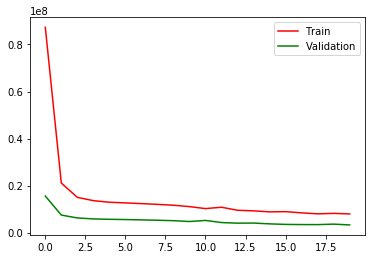

MSE: 


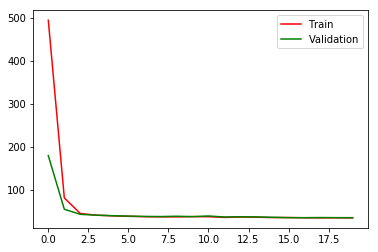

Ux: 


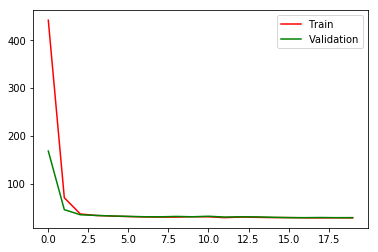

Uy: 


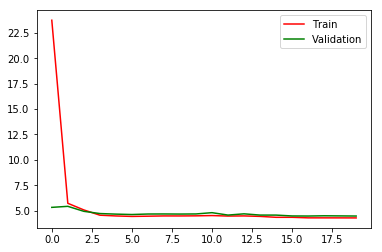

p: 


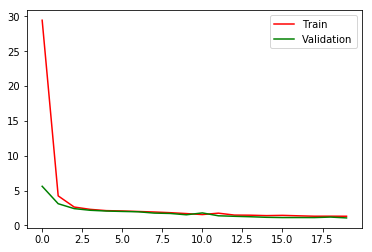

Output: 


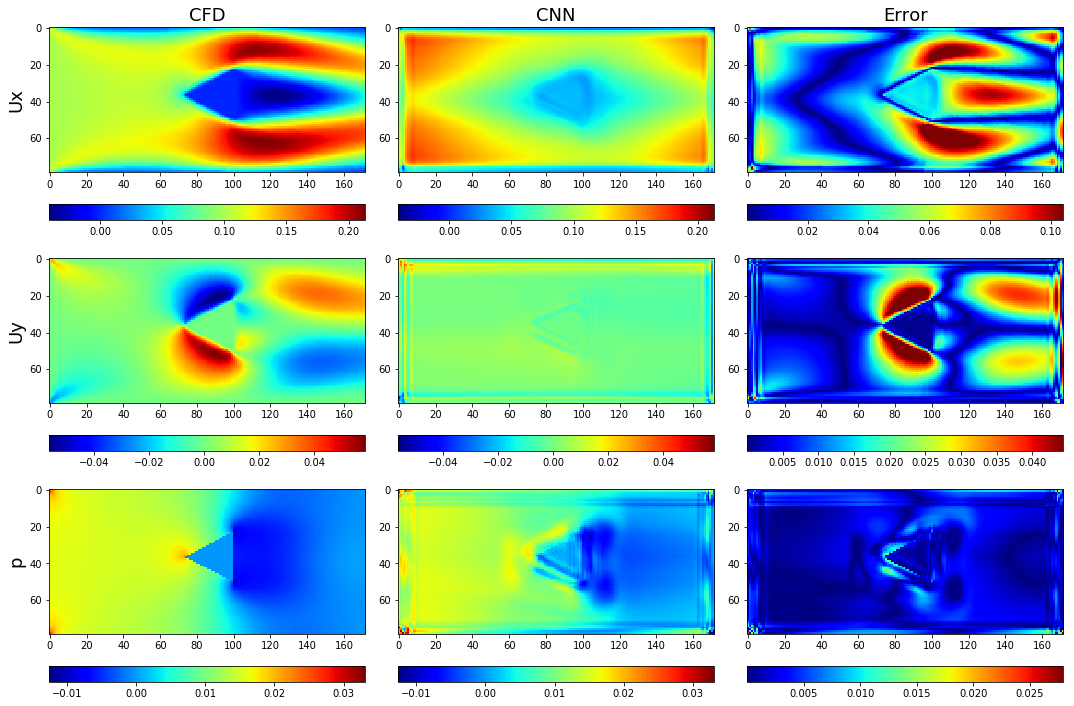

Best loss = 3248331.1875
Epoch #1
	Train Loss = 50320737.8125
	Train Total MSE = 169.48267800467355
	Train Ux MSE = 96.6128527323405
	Train Uy MSE = 41.78787088394165
	Train p MSE = 31.08195616517748
	Validation Loss = 6932591.9140625
	Validation Total MSE = 58.966103154482724
	Validation Ux MSE = 49.02448486539319
	Validation Uy MSE = 7.462211825030898
	Validation p MSE = 2.4794090582012718
Model saved!
Epoch #2
	Train Loss = 14040041.65625
	Train Total MSE = 48.511832101004465
	Train Ux MSE = 40.875068846203035
	Train Uy MSE = 5.387204647064209
	Train p MSE = 2.2495588944071816
	Validation Loss = 6494832.955078125
	Validation Total MSE = 50.53437773496634
	Validation Ux MSE = 43.050599464495704
	Validation Uy MSE = 5.0144544027255895
	Validation p MSE = 2.469324663848613
Model saved!
Epoch #3
	Train Loss = 12327037.90625
	Train Total MSE = 44.089723496210006
	Train Ux MSE = 37.524903796968005
	Train Uy MSE = 4.677161489214216
	Train p MSE = 1.887658519404275
	Validation Loss = 454724

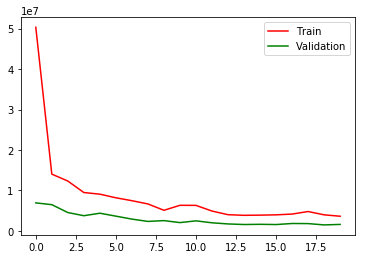

MSE: 


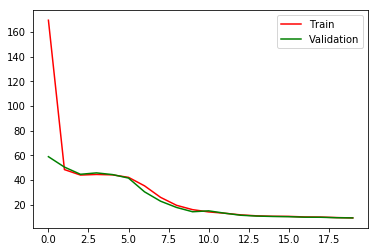

Ux: 


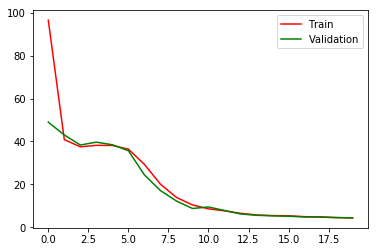

Uy: 


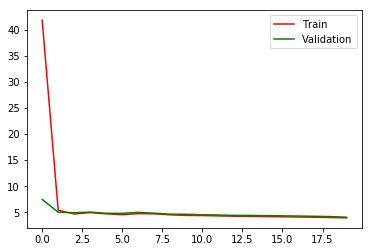

p: 


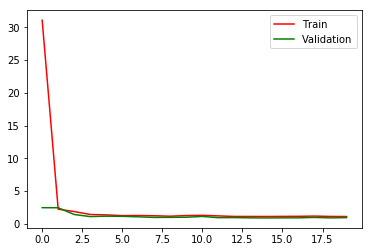

Output: 


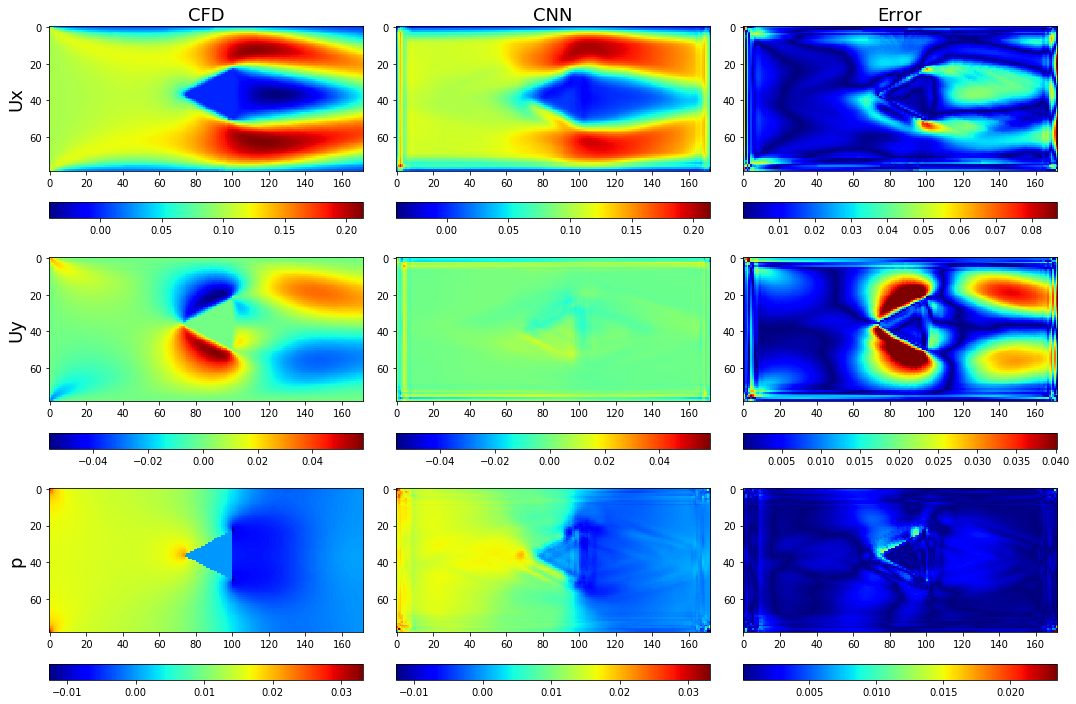

Best loss = 1491651.9575195312
Epoch #1
	Train Loss = 61016415.0
	Train Total MSE = 529.4672706240699
	Train Ux MSE = 515.9017813546317
	Train Uy MSE = 11.168304829370408
	Train p MSE = 2.397180628208887
	Validation Loss = 23621291.4140625
	Validation Total MSE = 468.2313099369458
	Validation Ux MSE = 459.47667981844046
	Validation Uy MSE = 6.694947645325974
	Validation p MSE = 2.0596741553408875
Model saved!
Epoch #2
	Train Loss = 50063392.5
	Train Total MSE = 421.39820643833707
	Train Ux MSE = 414.40486217680433
	Train Uy MSE = 4.8482483455113
	Train p MSE = 2.1450977751186917
	Validation Loss = 19764378.0
	Validation Total MSE = 376.2494525843426
	Validation Ux MSE = 369.5109006888314
	Validation Uy MSE = 4.301844384843503
	Validation p MSE = 2.4367059172231023
Model saved!
Epoch #3
	Train Loss = 42031818.375
	Train Total MSE = 338.2685953776042
	Train Ux MSE = 331.7508922758557
	Train Uy MSE = 4.112586373374576
	Train p MSE = 2.405115564664205
	Validation Loss = 16716866.44140625
	

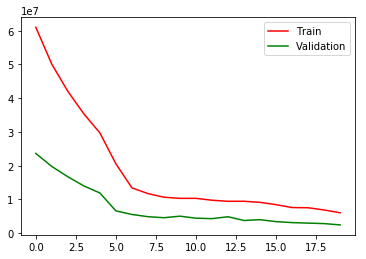

MSE: 


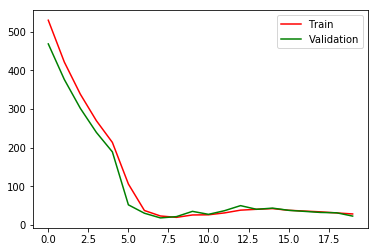

Ux: 


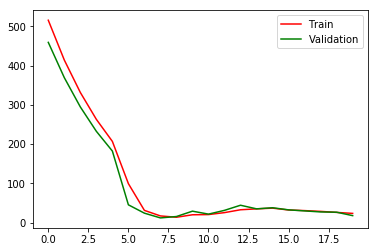

Uy: 


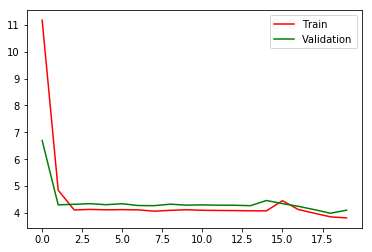

p: 


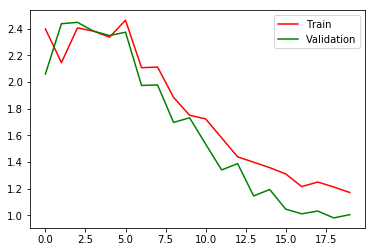

Output: 


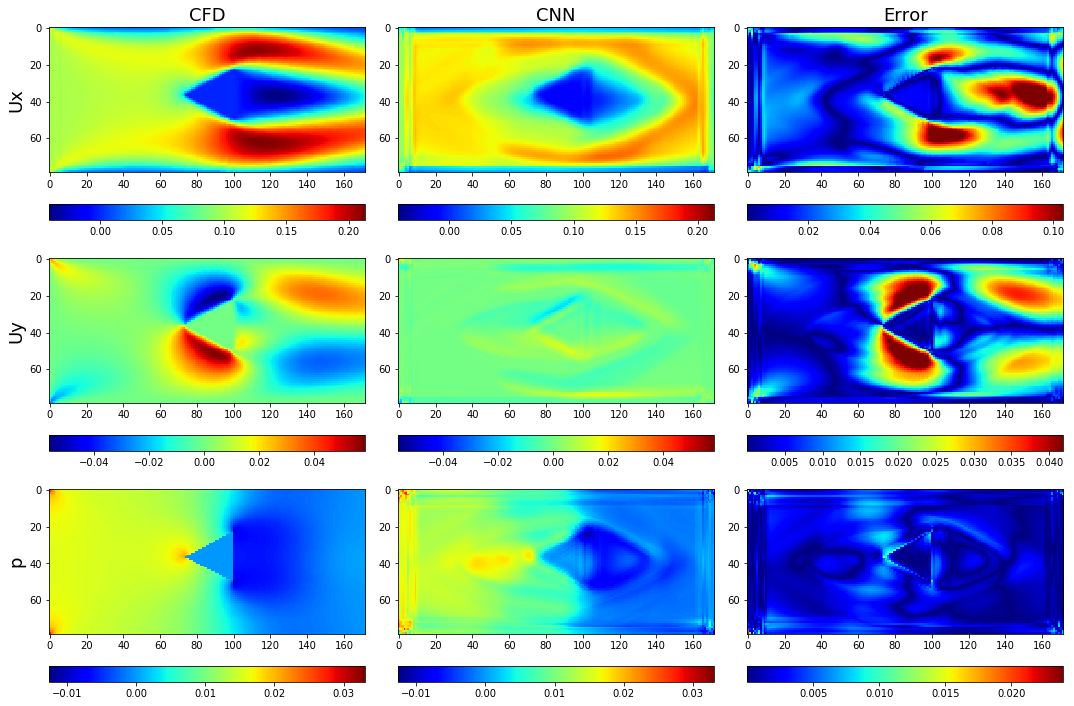

Best loss = 2443448.509765625


In [4]:
print("Evaluating configuration: ")
print(config)
torch.manual_seed(0)
train_loss_curves = []
test_loss_curves = []
train_mse_curves = []
test_mse_curves = []
train_ux_curves = []
test_ux_curves = []
train_uy_curves = []
test_uy_curves = []
train_p_curves = []
test_p_curves = []

for simulation_id in range(simulations):
    model = config["model"]
    lr = config["lr"]
    kernel_size = config["kernel"]
    filters = config["filters"]
    bn = config["bn"]
    wn = config["wn"]
    wd = config["wd"]
    model = model(3, 3, filters=filters, kernel_size=kernel_size,
                batch_norm=bn, weight_norm=wn)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    train_loss_curve = []
    test_loss_curve = []
    train_mse_curve = []
    test_mse_curve = []
    train_ux_curve = []
    test_ux_curve = []
    train_uy_curve = []
    test_uy_curve = []
    train_p_curve = []
    test_p_curve = []

    def after_epoch(scope):
        train_loss_curve.append(scope["train_loss"])
        test_loss_curve.append(scope["val_loss"])
        train_mse_curve.append(scope["train_metrics"]["mse"])
        test_mse_curve.append(scope["val_metrics"]["mse"])
        train_ux_curve.append(scope["train_metrics"]["ux"])
        test_ux_curve.append(scope["val_metrics"]["ux"])
        train_uy_curve.append(scope["train_metrics"]["uy"])
        test_uy_curve.append(scope["val_metrics"]["uy"])
        train_p_curve.append(scope["train_metrics"]["p"])
        test_p_curve.append(scope["val_metrics"]["p"])

    def loss_func(model, batch):
        x, y = batch
        output = model(x)
        lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) #/ channels_weights
        lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) #/ channels_weights
        lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) #/ channels_weights
        loss = (lossu + lossv + lossp)/channels_weights
        return torch.sum(loss), output

    # Training model
    best_model, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
            epochs=epochs, batch_size=batch_size, device=device,
            m_mse_name="Total MSE",
            m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
            m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
            m_ux_name="Ux MSE",
            m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
            m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
            m_uy_name="Uy MSE",
            m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
            m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
            m_p_name="p MSE",
            m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
            m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=epochs, after_epoch=after_epoch
            )
    # Storing curves
    train_loss_curves.append(train_loss_curve)
    test_loss_curves.append(test_loss_curve)
    train_mse_curves.append(train_mse_curve)
    test_mse_curves.append(test_mse_curve)
    train_ux_curves.append(train_ux_curve)
    test_ux_curves.append(test_ux_curve)
    train_uy_curves.append(train_uy_curve)
    test_uy_curves.append(test_uy_curve)
    train_p_curves.append(train_p_curve)
    test_p_curves.append(test_p_curve)
    # Plotting curves
    print("Loss: ")
    plt.figure()
    plt.plot(train_loss_curve, "-r", label='Train')
    plt.plot(test_loss_curve, "-g", label='Validation')
    plt.legend()
    plt.show()
    print("MSE: ")
    plt.close()
    plt.figure()
    plt.plot(train_mse_curve, "-r", label='Train')
    plt.plot(test_mse_curve, "-g", label='Validation')
    plt.legend()
    plt.show()
    print("Ux: ")
    plt.close()
    plt.figure()
    plt.plot(train_ux_curve, "-r", label='Train')
    plt.plot(test_ux_curve, "-g", label='Validation')
    plt.legend()
    plt.show()
    plt.close()
    print("Uy: ")
    plt.figure()
    plt.plot(train_uy_curve, "-r", label='Train')
    plt.plot(test_uy_curve, "-g", label='Validation')
    plt.legend()
    plt.show()
    print("p: ")
    plt.close()
    plt.figure()
    plt.plot(train_p_curve, "-r", label='Train')
    plt.plot(test_p_curve, "-g", label='Validation')
    plt.legend()
    plt.show()
    plt.close()
    # Plotting results
    print("Output: ")
    with torch.no_grad():
        test_sample_out = best_model(test_sample_x)
    visualize(test_sample_y.cpu().numpy(), test_sample_out.cpu().numpy())
    plt.show()
    plt.close()
    print("Best loss = " + str(test_loss))

In [5]:
train_loss_curves = torch.FloatTensor(train_loss_curves)
test_loss_curves = torch.FloatTensor(test_loss_curves)
train_mse_curves = torch.FloatTensor(train_mse_curves)
test_mse_curves = torch.FloatTensor(test_mse_curves)
train_ux_curves = torch.FloatTensor(train_ux_curves)
test_ux_curves = torch.FloatTensor(test_ux_curves)
train_uy_curves = torch.FloatTensor(train_uy_curves)
test_uy_curves = torch.FloatTensor(test_uy_curves)
train_p_curves = torch.FloatTensor(train_p_curves)
test_p_curves = torch.FloatTensor(test_p_curves)

In [10]:
def plot_curves(train, test, title=""):
    train_mean = train.mean(dim=0)
    train_std = train.std(dim=0)
    test_mean = test.mean(dim=0)
    test_std = test.std(dim=0)
    plt.figure()
    plt.title(title)
    plt.fill_between(np.arange(len(train_std)), train_mean + train_std, train_mean - train_std, color=(1, 0, 0, 0.2))
    plt.fill_between(np.arange(len(test_std)), test_mean + test_std, test_mean - test_std, color=(0, 1, 0, 0.2))
    plt.plot(train_mean, "-r", label='Train')
    plt.plot(test_mean, "-g", label='Validation')
    plt.legend()
    plt.show()
    print("Best Train Mean = " + str(float(torch.mean(torch.min(train, dim=0)[0]))))
    print("Best Validation Mean = " + str(float(torch.mean(torch.min(test, dim=0)[0]))))
    print("Best Train SD = " + str(float(torch.std(torch.min(train, dim=0)[0]))))
    print("Best Validation SD = " + str(float(torch.std(torch.min(test, dim=0)[0]))))
    

Loss: 


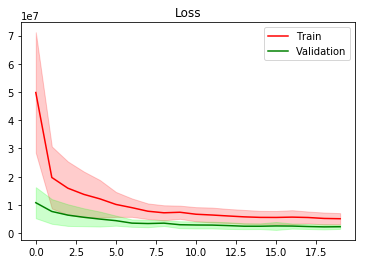

Best Train Mean = 5673042.0
Best Validation Mean = 2176271.5
Best Train SD = 4616510.5
Best Validation SD = 1299874.375
MSE: 


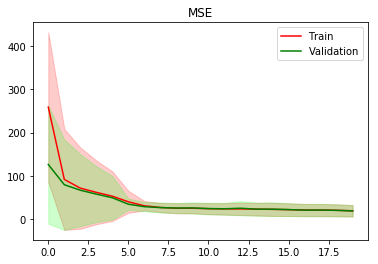

Best Train Mean = 16.4710693359375
Best Validation Mean = 14.935434341430664
Best Train SD = 12.3453369140625
Best Validation SD = 9.43685531616211
Ux: 


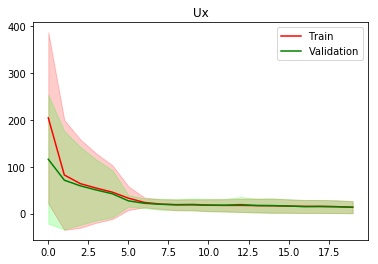

Best Train Mean = 10.032748222351074
Best Validation Mean = 8.814132690429688
Best Train SD = 10.729425430297852
Best Validation SD = 8.378722190856934
Uy: 


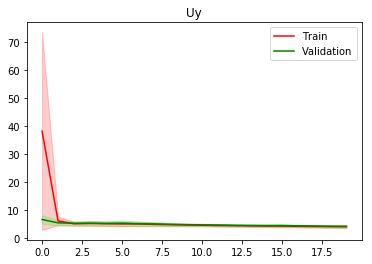

Best Train Mean = 4.064183235168457
Best Validation Mean = 4.178350448608398
Best Train SD = 0.43853938579559326
Best Validation SD = 0.2780153751373291
p: 


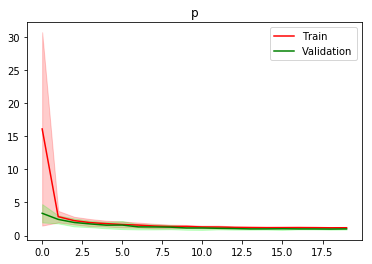

Best Train Mean = 1.2709009647369385
Best Validation Mean = 1.038761854171753
Best Train SD = 0.3552526533603668
Best Validation SD = 0.28622278571128845


In [11]:
print("Loss: ")
plot_curves(train_loss_curves, test_loss_curves, "Loss")
print("MSE: ")
plot_curves(train_mse_curves, test_mse_curves, "MSE")
print("Ux: ")
plot_curves(train_ux_curves, test_ux_curves, "Ux")
print("Uy: ")
plot_curves(train_uy_curves, test_uy_curves, "Uy")
print("p: ")
plot_curves(train_p_curves, test_p_curves, "p")